In [1]:
# from llm_workflow.openai import OpenAIChat

# model = OpenAIChat()

# model("hello")

'Hello! How can I assist you today?'

In [42]:
# load yaml file

from abc import ABC, abstractmethod
from textwrap import dedent
from pydantic import BaseModel, field_validator
import yaml
from enum import Enum

# enum Priority
class Priority(str, Enum):
    low = 'low'
    medium = 'medium'
    high = 'high'


class Note(ABC, BaseModel):
    priority: Priority = Priority.medium
    reference: str | None = None
    tags: list[str] = []

    def uuid(self):
        """Return a unique identifier for the note (e.g. a hash of the content)."""
        return hash('-'.join([f"{k}={v}" for k, v in self.dict().items()]))

    @abstractmethod
    def preview(self):
        """Render the 'preview' e.g. the 'question' or 'term' to give context."""

    @abstractmethod
    def note(self):
        """Render the 'description' e.g. the 'answer' or 'definition' to provide more detail."""


class TextNote(Note):
    text: str

    @field_validator('text')
    @classmethod
    def text_validator(cls, t: str) -> str:
        return dedent(t).strip()

    def preview(self):
        return self.text

    def note(self):
        return self.text


class DefinitionNote(Note):
    term: str
    definition: str

    @field_validator('term')
    @classmethod
    def term_validator(cls, t: str) -> str:
        return dedent(t).strip()
    
    @field_validator('definition')
    @classmethod
    def definition_validator(cls, d: str) -> str:
        return dedent(d).strip()

    def preview(self):
        return self.term

    def note(self):
        return self.definition


class QuestionAnswerNote(Note):
    question: str
    answer: str

    @field_validator('question')
    @classmethod
    def term_validator(cls, q: str) -> str:
        return dedent(q).strip()
    
    @field_validator('answer')
    @classmethod
    def definition_validator(cls, a: str) -> str:
        return dedent(a).strip()

    def preview(self):
        return self.question

    def note(self):
        return self.answer  


class ClassNotes(BaseModel):
    name: str
    notes: list[Note] = []
    ident: str | None = None
    abbreviation: str | None = None
    category: str | None = None
    tags: list[str] = []

    @classmethod
    def from_dict(cls, data: dict):
        """Create a ClassNotes object from a dictionary."""
        notes = []
        for note in data['notes']:
            if isinstance(note, str):
                notes.append(TextNote(text=note))
            elif isinstance(note, dict):
                if 'text' in note:
                    notes.append(TextNote(**note))
                elif 'term' in note and 'definition' in note:
                    notes.append(DefinitionNote(**note))
                elif 'question' in note and 'answer' in note:
                    notes.append(QuestionAnswerNote(**note))
                else:
                    raise ValueError(f"Invalid note type: {note}")
            else:
                raise ValueError(f"Invalid note type: {note}")
        data['notes'] = notes
        return ClassNotes(**data)


with open("../../tests/test_files/notes1.yaml", "r") as f:
    notes = yaml.safe_load(f)


class_notes = ClassNotes.from_dict(notes)
print(class_notes)

name='Introduction to Operating Systems' notes=[TextNote(priority=<Priority.medium: 'medium'>, reference=None, tags=[], text='This\nis\na\nmultiline\nnote.'), TextNote(priority=<Priority.medium: 'medium'>, reference=None, tags=[], text='This is another note.'), TextNote(priority=<Priority.high: 'high'>, reference='https://www.example.com', tags=[], text='This is a note with a reference.'), DefinitionNote(priority=<Priority.high: 'high'>, reference='https://www.example.com', tags=['Exam 1', 'Paper1'], term='Term', definition='Definition')] ident='CS 6200' abbreviation='GIOS' category='OMSCS' tags=['systems']


In [344]:
import numpy as np

class StudyNotes:
    def __init__(self, class_notes: list[ClassNotes], history: dict[int, tuple[int, int]] | None = None):
        self.history = history or {}
        self.class_notes = class_notes
        # TODO it's possible that notes from different classes (or the same) have the same uuid
        self.test_bank = {}
        for class_note in class_notes:
            for note in class_note.notes:
                self.test_bank[note.uuid()] = {
                    'class-category': class_note.category,
                    'class-ident': class_note.ident,
                    'class-name': class_note.name,
                    'class-abbreviation': class_note.abbreviation,
                    'class-tags': class_note.name,
                    'note-priority': note.priority,
                    'note-reference': note.reference or '',
                    'note-tags': note.tags,
                    'note-preview': note.preview(),
                    'note-note': note.note(),
                    'history': self.history[note.uuid()] if note.uuid() in self.history else (1, 1),
                }

    def draw(self):
        """Draw a note from the class notes."""
        probabilities = {
            k: np.random.beta(v['history'][0], v['history'][1], 1)[0]
            for k, v in self.test_bank.items()
        }
        # softmax probabilities across all values
        sum_probs = sum(probabilities.values())
        probabilities = {k: v / sum_probs for k, v in probabilities.items()}
        # draw a note
        note_uuid = np.random.choice(list(probabilities.keys()), p=list(probabilities.values()))
        return self.test_bank[note_uuid]


study = StudyNotes([class_notes])
study.draw()

{'class-category': 'OMSCS',
 'class-ident': 'CS 6200',
 'class-name': 'Introduction to Operating Systems',
 'class-abbreviation': 'GIOS',
 'class-tags': 'Introduction to Operating Systems',
 'note-priority': <Priority.high: 'high'>,
 'note-reference': 'https://www.example.com',
 'note-tags': ['Exam 1', 'Paper1'],
 'note-preview': 'Term',
 'note-note': 'Definition',
 'history': (1, 1)}

(0.0, 1.0)

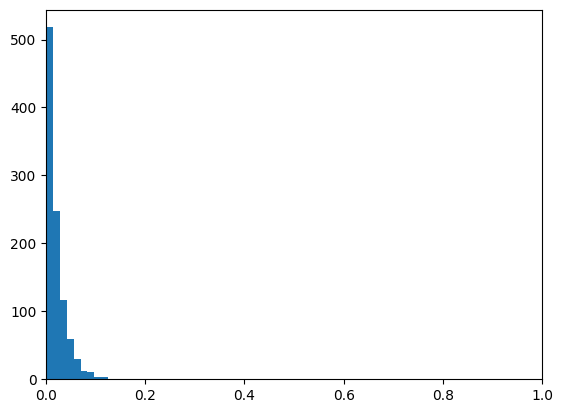

In [168]:
# use beta distribution to draw notes
import numpy as np
import matplotlib.pyplot as plt

# beta distribution
correct, wrong = 50, 1
# beta is the distribution of the probability of success
beta = np.random.beta(correct, wrong, 1000)
# if the probability of success (of answering the question) is high, then there is less need to study it and we can draw it less often
beta = 1 - beta
plt.hist(beta, bins=10)
# fix the x-axis between 0 and 1
plt.xlim(0, 1)